In [1]:
import sys
sys.path.append("../../../../")
import model

import warnings
import numpy as np
import leidenalg
import igraph as ig
import scanpy as sc
import anndata as ad
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import graph
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
# import custom functions
import utils
import os
from tqdm import tqdm
import torch.optim as optim
from torch_geometric.nn import GCNConv
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from validclust import dunn
# import custom functions
from sklearn.metrics import pairwise_distances
plt.rcParams["figure.figsize"] = (8, 6)


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SNAP_GNN(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.fc = nn.Linear(in_features=args.gnn_input_dim, out_features=args.fc_dim)
        self.cnn_fc = nn.Linear(in_features=args.cnn_input_dim, out_features=args.cnn_dim)
        self.feat_conv1 = GCNConv(args.fc_dim, args.latent_dim)
        self.feat_conv2 = GCNConv(args.latent_dim, args.fc_out_dim)
        
        self.spat_conv1 = GCNConv(args.cnn_dim, args.cnn_latent_dim)
        self.spat_conv2 = GCNConv(args.cnn_latent_dim, args.cnn_out_dim)
        
        self.proj1 = nn.Linear(in_features=args.fc_out_dim+args.cnn_out_dim, 
                              out_features=args.hid_out_dim)
        self.proj2 = nn.Linear(in_features=args.hid_out_dim, 
                              out_features=args.out_dim)
        #self.proj = nn.Linear(in_features=args.fc_out_dim+args.cnn_out_dim, 
                              #out_features=args.out_dim)

    def feat_gnn_encoder(self, feat, feat_edge_index):
        feat = F.relu(self.fc(feat))
        feat = F.relu(self.feat_conv1(feat, feat_edge_index))
        feat = self.feat_conv2(feat, feat_edge_index)
        
        return feat
    
    def spat_gnn_encoder(self, spat, spat_edge_index):
        spat = F.relu(self.cnn_fc(spat))
        spat = F.relu(self.spat_conv1(spat, spat_edge_index))
        spat = self.spat_conv2(spat, spat_edge_index)
        
        return spat
    
    def encoder(self, feat, spat, feat_edge_index, spat_edge_index):
        x_feat = self.feat_gnn_encoder(feat, feat_edge_index)
        x_spat = self.spat_gnn_encoder(spat, spat_edge_index)
        x = torch.cat((x_feat, x_spat), dim = 1)
        return x
    

    def forward(self, feat, spat, feat_edge_index, spat_edge_index):
        x = F.relu(self.encoder(feat, spat, feat_edge_index, spat_edge_index))
        x = self.proj1(x)
        x = F.relu(x)
        x = self.proj2(x)
        return x


In [3]:
class Args:
    gnn_input_dim = 30 # doing 30 pc here
    cnn_input_dim = 128
    fc_dim = latent_dim = 32
    cnn_dim = cnn_latent_dim = 32
    out_dim = 11 * 2
    #fc_out_dim = cnn_out_dim = 16
    fc_out_dim = 33
    cnn_out_dim = 11
    hid_out_dim = 33
    # fc_out_dim = 30
    # cnn_out_dim = 10
    # hid_out_dim = 30


    criterion = "L1"
    learning_rate = 1e-3
    epochs = 10000
    print_every = 1000
    average_iter = 100
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

args = Args()

In [4]:
# bokai 
metaload_path = '../data/'
# sheng other meta
metaload_path2 = '../data/' # only for images etc

cell_nbhd = np.load(os.path.join(metaload_path,  "469_cell_nbhd_res0.5_k20.npy"))
train_mask = np.load(os.path.join(metaload_path2, "469_train_mask.npy"))
feature_labels = np.load(os.path.join(metaload_path,  "469_feature_labels_res0.5.npy"))
feature_edges = np.load(os.path.join(metaload_path,  "469_feature_edges_res0.5.npy"))
spatial_edges = np.load(os.path.join(metaload_path,  "spatial_edges_0325.npy"))

In [5]:
print([cell_nbhd.shape, train_mask.shape, len(np.unique(feature_labels))])

[(54867, 11), (54867,), 11]


In [6]:
meta = pd.read_csv('../data/livcan_meta_y4_x69.csv')
pc = np.load('../data/469_pc.npy')[:,:30]
print([meta.shape, pc.shape])

[(54867, 63), (54867, 30)]


In [7]:
features = torch.from_numpy(pc).float().to(args.device)
feat_edge_index = torch.from_numpy(np.array(feature_edges.T[:2])).long().to(args.device)
spat_edge_index = torch.from_numpy(np.array(spatial_edges.T[:2])).long().to(args.device)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
cnn_embedding = np.load("../data/469_cnn/cnn_512_l1_layer6/epochs/embed/cnn_512_notrans_l1_layer6_byepoch/469_cnn_embedding_512_full_l1_dim128_epoch400.npy")
args.criterion = "L1"
verbose = True
model = SNAP_GNN(args)
cnn_feature = torch.from_numpy(cnn_embedding).float().to(args.device)

In [9]:
meta['res0.5'] = feature_labels
reslabel = pd.get_dummies(meta['res0.5'])
combo_nbhd = np.hstack([reslabel, cell_nbhd])
print(combo_nbhd.shape)
combo_nbhd = torch.from_numpy(combo_nbhd).float().to(args.device)

(54867, 22)


In [10]:
def get_gnn_embed(model, cell_nbhd, feat, spat, feat_edge_index, spat_edge_index, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    cell_nbhd = cell_nbhd.to(args.device)
    model = model.to(args.device)
    if args.criterion == "L1":
        print("Use L1 Loss")
        criterion = nn.L1Loss()
    elif args.criterion == "L2":
        print("Use L2 Loss")
        criterion = nn.MSELoss()
    else:
        print("Cross Entropy")
        criterion = nn.CrossEntropyLoss()

    train_loss_epoch = []
    #criterion = nn.L1Loss()
    for e in range(1, 1+args.epochs):
        model.train()
        predicted_nbhd = model(features, cnn_feature, feat_edge_index, spat_edge_index)
        # Compute prediction error
        loss = criterion(predicted_nbhd, cell_nbhd)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # take one step
        optimizer.step()

        # record the loss
        curr_train_loss = loss.item()
        if verbose and e % args.print_every  == 0:
            print(f'===Epoch {e}, the training loss is {curr_train_loss:>0.8f}==', flush=True)
        train_loss_epoch.append(curr_train_loss)
    return model.encoder(feat, spat, feat_edge_index, spat_edge_index).cpu().detach().numpy()


In [11]:
stable = True
if stable:
    rep = 5
    dim = args.fc_out_dim + args.cnn_out_dim
    concat_embedding = np.zeros((features.shape[0], rep * dim))
    for i in range(rep):
        gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn_feature, feat_edge_index, spat_edge_index, verbose=True)
        concat_embedding[:, i*dim : (i+1)*dim] = gnn_embedding
    Ue, Se, Vhe = np.linalg.svd(concat_embedding, full_matrices=False)

    plt.plot(Se)
    k = 32
    gnn_embedding = Ue[:, :k] @ np.diag(Se[:k])
else:
    gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn_feature, feat_edge_index, spat_edge_index, verbose=True)


Use L1 Loss


In [ ]:
gnn_adata = ad.AnnData(gnn_embedding)
sc.pp.scale(gnn_adata)
gnn_adata.obs['annotation'] = list(meta['cellType'])
sc.tl.pca(gnn_adata, svd_solver='arpack')
# sc.pp.neighbors(feature_adata, n_neighbors=10, n_pcs=40)

/tmp/ipykernel_1724926/635900885.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  gnn_adata = ad.AnnData(gnn_embedding)


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

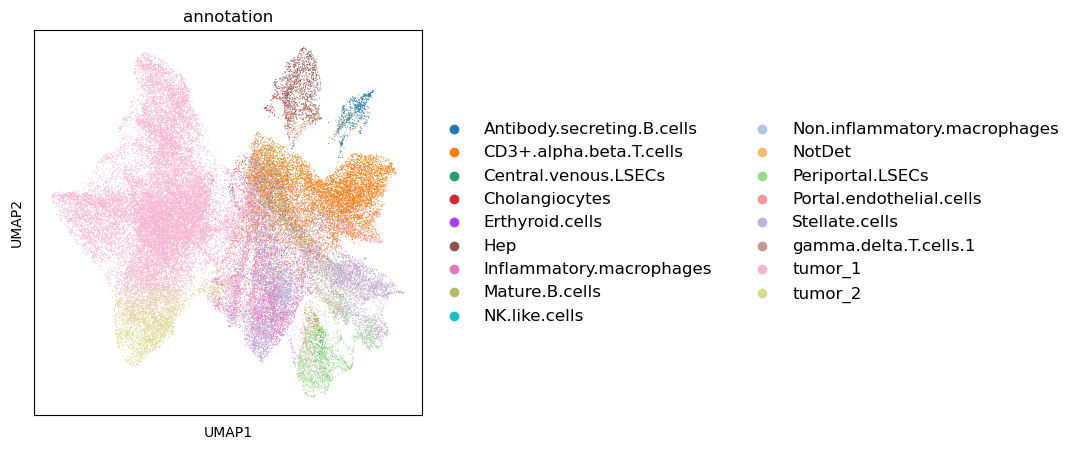

In [ ]:
sc.pp.neighbors(gnn_adata, n_neighbors=10)
sc.tl.umap(gnn_adata)
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.umap(gnn_adata, color='annotation', legend_fontsize=12, show=False)

In [14]:
save_folder = '../data/'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
np.save(os.path.join(save_folder, f"469_double_snap_combo_stable_0326.npy"), gnn_embedding)